# Master Setup Cell



## Imports and Data Loading

In [66]:
#Load tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [67]:
#Import data from Google drive and data checking
from google.colab import drive
drive.mount("/content/drive")

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sephora skincare product.csv")

df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   type         1472 non-null   object 
 1   brand        1472 non-null   object 
 2   name         1472 non-null   object 
 3   price        1472 non-null   int64  
 4   rating       1472 non-null   float64
 5   ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


In [68]:
#CHECK FOR DUPLICATES
print("\n--- DUPLICATE CHECK ---")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


--- DUPLICATE CHECK ---
Number of duplicate rows: 0


In [69]:
#Check first 3 row ensure data validity
display(df.head(3))

,type,brand,name,price,rating,ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0


In [70]:
#Categories in the type column
df['type'].unique()

array(['Moisturizer', 'Cleanser', 'Treatment', 'Face Mask', 'Eye cream',
       'Sun protect'], dtype=object)

# Category Saturation Map

,type,unique_brands,total_skus,avg_price,avg_rating,saturation_index
3,Moisturizer,63,298,69.09,69.1,4.7
0,Cleanser,72,281,32.60,32.6,3.9
2,Face Mask,63,266,42.62,42.6,4.2
5,Treatment,64,248,79.18,79.2,3.9
1,Eye cream,71,209,63.60,63.6,2.9
4,Sun protect,56,170,45.91,45.9,3.0


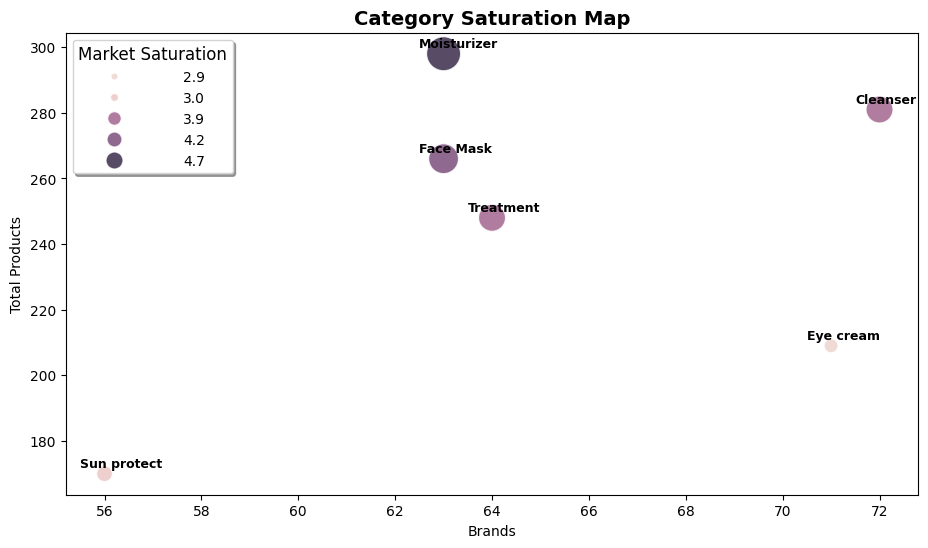

In [71]:
# Create a new table and group by type
Category_comp = df.groupby('type').agg(
    unique_brands=('brand', 'nunique'),
    total_skus=('name', 'count'),
    avg_price=('price', 'mean'),
    avg_rating=('rating', 'mean')
).reset_index()

Category_comp['avg_price'] = Category_comp['avg_price'].round(2)
Category_comp['avg_rating'] = Category_comp['avg_price'].round(1)

# Create a new column of saturation_index
Category_comp['saturation_index'] = round(Category_comp['total_skus'] / Category_comp['unique_brands'], ndigits=1)
Category_comp = Category_comp.sort_values(by='total_skus', ascending=False)

# Display the Comparison table by categories
display(Category_comp)

#Plot the scatter diagram of Categories Saturation
plt.figure(figsize=(11, 6))
sns.scatterplot(
    data=Category_comp,
    x='unique_brands',
    y='total_skus',
    size='saturation_index',
    hue='saturation_index',
    sizes=(100, 600),
    alpha = 0.8,
)

# Label the bubbles
for i in range(len(Category_comp)):
    plt.text(
        Category_comp.unique_brands[i]-0.5,
        Category_comp.total_skus[i]+2,
        Category_comp.type[i],
        fontsize=9,
        weight='bold',
        color='black'
    )


plt.title('Category Saturation Map', fontsize=14, fontweight="bold")
plt.xlabel('Brands')
plt.ylabel('Total Products')

#Customise the legend
plt.legend(
    title='Market Saturation',
    title_fontsize = '12',
    edgecolor = 'lightgrey',
    shadow=True,
    markerscale = 0.5,
    columnspacing = 50,
    alignment = 'center',
    handletextpad = 4,
    labelspacing = 0.5,
)

plt.show()

#Eye Cream Premium & Luxury Products Analysis

## Filtering

In [72]:
# Creates a new distinct copy of table including only eye cream products
eye_df = df[df['type']=='Eye cream'].copy()

# Calculations to filter out unwanted products
avg_eye_price = eye_df['price'].mean()
luxury_threshold = 1.2 * avg_eye_price

# Create a new distinct copy of the 'High Value' Segment
luxury_threshold_eye_df = eye_df[eye_df['price'] >= luxury_threshold].copy()

# SUMMARY OUTPUT
print("\n--- MARKET SEGMENTATION SUMMARY ---")
print(f"Average Eye Product Price:  ${avg_eye_price:.2f}")
print(f"Luxury Range: ${luxury_threshold:.2f}")
print("-" * 30)
print(f"Total Eye Products:         {len(eye_df)}")
print(f"Target 'High Value' Count:  {len(luxury_threshold_eye_df)} products")
print("-" * 30)


--- MARKET SEGMENTATION SUMMARY ---
Average Eye Product Price:  $63.60
Luxury Range: $76.32
------------------------------
Total Eye Products:         209
Target 'High Value' Count:  40 products
------------------------------


## Luxury Eye Cream Products: Price vs Rating Correlation

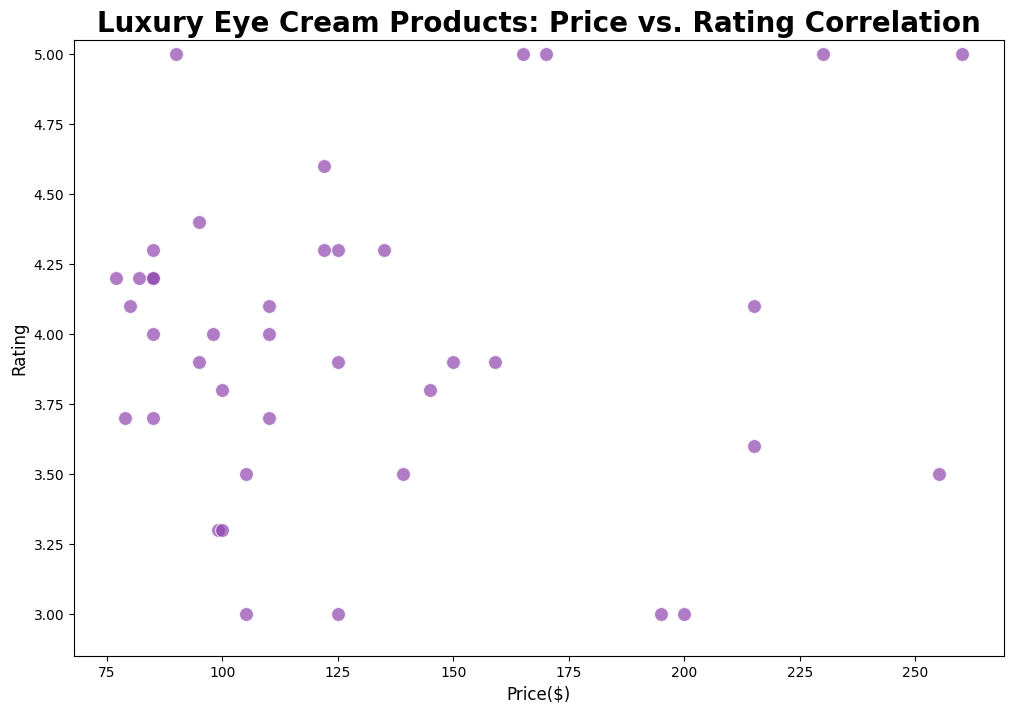

In [73]:
plt.figure(figsize=(12, 8))

# Scatter Plot
sns.scatterplot(
    data=luxury_threshold_eye_df,
    x='price',
    y='rating',
    s=100,
    color='#8E44AD',
    alpha=0.7,
    edgecolor='white'
)

plt.title('Luxury Eye Cream Products: Price vs. Rating Correlation', fontsize=20, fontweight='bold')
plt.xlabel('Price($)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.ylim(2.85, 5.05)
plt.show()

## Luxury Eye Cream: Competitors Analysis

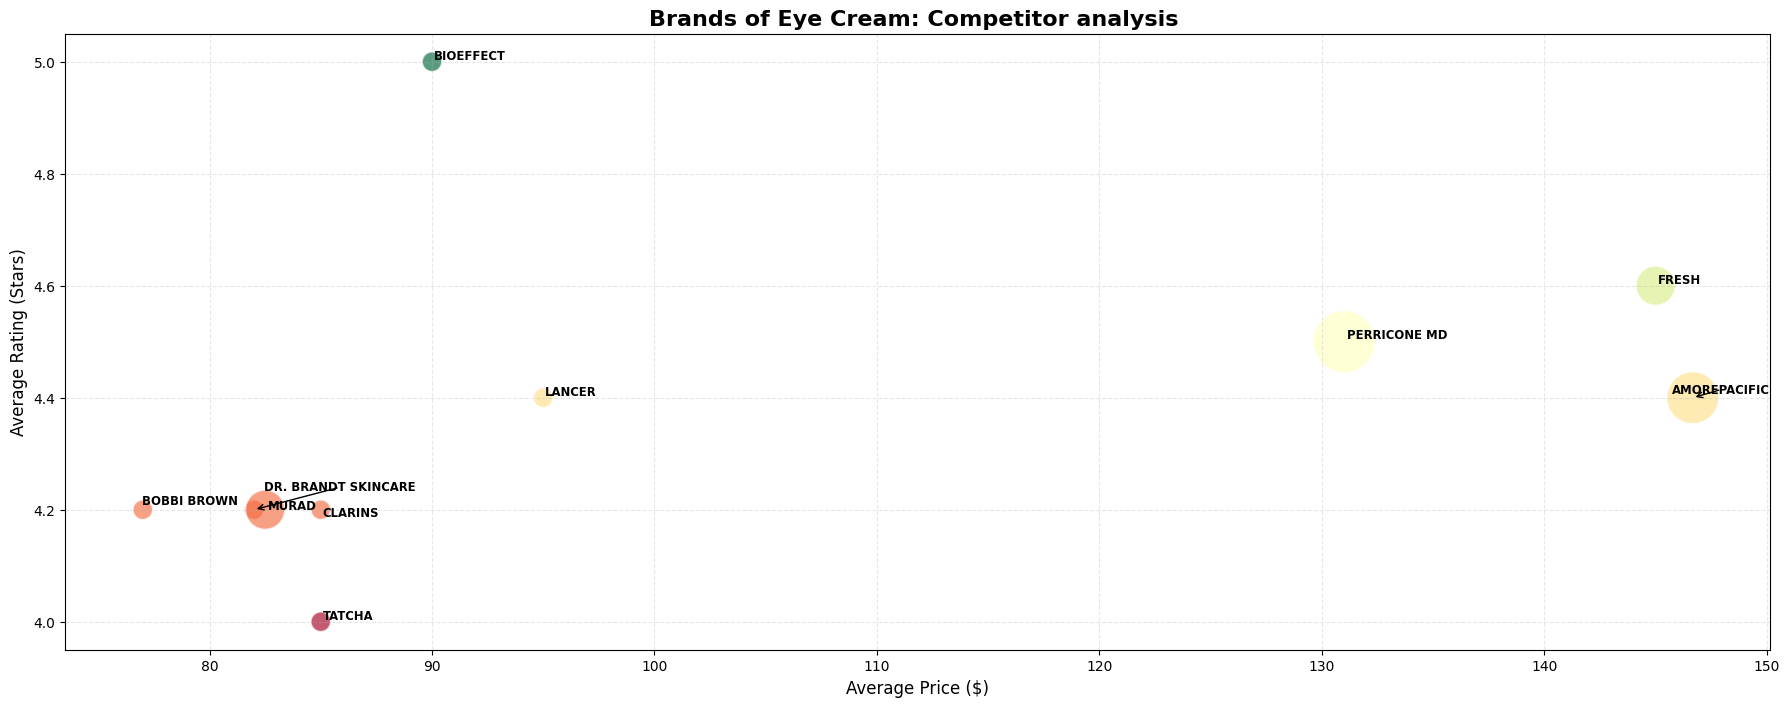

In [74]:
# Create the dataframe for brand matrix analysis
brand_matrix = luxury_threshold_eye_df.groupby('brand').agg(
    avg_price=('price', 'mean'),
    avg_rating=('rating', 'mean'),
    product_count=('name', 'count')
).reset_index()

brand_matrix['avg_price'] = brand_matrix['avg_price'].round(2)
brand_matrix['avg_rating'] = brand_matrix['avg_rating'].round(1)

# Take 10 for analysis
top_10_competitors = brand_matrix.sort_values(
    by=['avg_rating','avg_price'],ascending=[False,True]).head(10).reset_index(drop=True)

# Plot the competitors analysis
plt.figure(figsize=(22, 8))

sns.scatterplot(
    data=top_10_competitors,
    x='avg_price',
    y='avg_rating',
    size='product_count',
    sizes=(200, 2000),
    hue='avg_rating',
    palette='RdYlGn', # Red to Green
    legend=False,
    edgecolor='white',
    alpha=0.65
)

# Intelligent Labeling
texts = []
for i in range(len(top_10_competitors)):
    texts.append(plt.text(
        top_10_competitors.avg_price.iloc[i],
        top_10_competitors.avg_rating.iloc[i],
        top_10_competitors.brand.iloc[i],
        size='small',
        weight='bold',
        color='black'
    ))

# Adjust text location to avoid overlapping
!pip install adjustText
from adjustText import adjust_text

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='black', lw=1),
    force_points=1
)

plt.title('Brands of Eye Cream: Competitor analysis ', fontsize=16, fontweight='bold')
plt.xlabel('Average Price ($)', fontsize=12)
plt.ylabel('Average Rating (Stars)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## High Frequent Ingredients Influence

### High Frequent Ingredients in Eye Cream: The noise

In [75]:
# Create a list of ingredients in high-value eye cream
eye_ingredients = []
for index, row in luxury_threshold_eye_df.iterrows():
    ing_text = str(row['ingredients']).lower()
    current_list = [x.strip() for x in ing_text.split(',')]
    eye_ingredients.extend(current_list)

ing_series = pd.Series(eye_ingredients)

#Find out the top 5 ingredients and define them as noise
top_5_ing = ing_series.value_counts().head(5)

print(top_5_ing)

# Summarise the Noise Ingredients in a Table
noise_table = pd.DataFrame({
    'Ingredient': top_5_ing.index.str.title(),
    'Count': top_5_ing.values,
    'Saturation %': ((top_5_ing.values / len(luxury_threshold_eye_df)) * 100).round(1)
})

display(noise_table)

# Save the noise list
eye_noise = top_5_ing.index.tolist()

glycerin           31
water              27
phenoxyethanol     25
butylene glycol    23
dimethicone        19
Name: count, dtype: int64


,Ingredient,Count,Saturation %
0,Glycerin,31,77.5
1,Water,27,67.5
2,Phenoxyethanol,25,62.5
3,Butylene Glycol,23,57.5
4,Dimethicone,19,47.5


### High Frequent Ingredients in Eye Cream Excluding The Noise

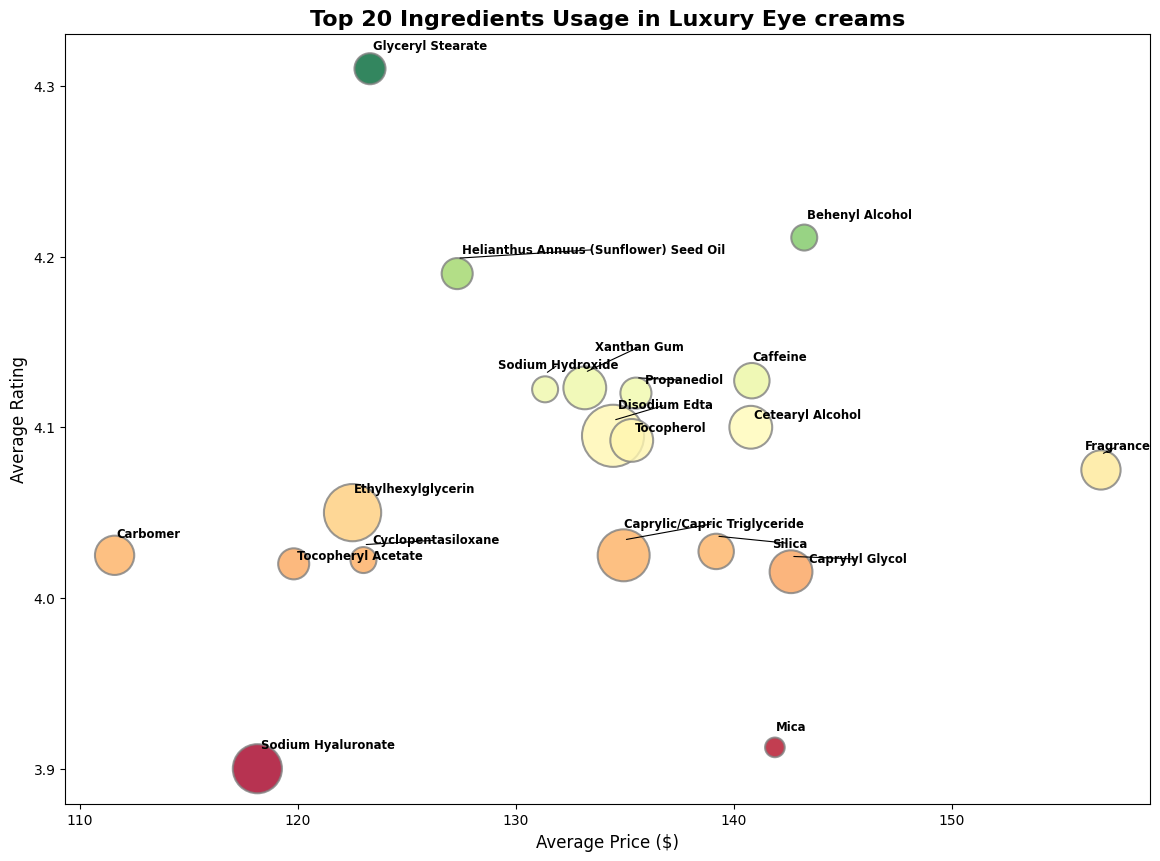

In [76]:
# 1. Filter out Ingredients
filtered_ing = []
for index, row in luxury_threshold_eye_df.iterrows():
    ing_text = str(row['ingredients']).lower()
    current_list = [x.strip() for x in ing_text.split(',')]
    for ing in current_list:
        if ing not in eye_noise:
            filtered_ing.append(ing)

# Create a list of Top 20 High usage ingredients
top_20_hv_actives = pd.Series(filtered_ing).value_counts().head(20).index.tolist()

# 2. CALCULATE METRICS
hv_matrix_data = []
for ing in top_20_hv_actives:
    matches = luxury_threshold_eye_df[luxury_threshold_eye_df['ingredients'].str.lower().str.contains(ing, regex=False)]
    if len(matches) > 0:
        hv_matrix_data.append({
            'Ingredient': ing.title(),
            'Avg_Price': matches['price'].mean(),
            'Avg_Rating': matches['rating'].mean(),
            'Product_Count': len(matches)
        })

hv_matrix_df = pd.DataFrame(hv_matrix_data)

# Plot the Scatter Plot with the size of dots relate to the product number
plt.figure(figsize=(14, 10))

sns.scatterplot(
    data=hv_matrix_df,
    x='Avg_Price',
    y='Avg_Rating',
    size='Product_Count',
    sizes=(200, 2000),
    hue='Avg_Rating',
    palette='RdYlGn',
    alpha=0.8,
    edgecolor='grey',
    legend=False
)

# Labelling ingredients
texts = []
for i in range(hv_matrix_df.shape[0]):
    texts.append(plt.text(
        hv_matrix_df.Avg_Price.iloc[i],
        hv_matrix_df.Avg_Rating.iloc[i]+0.009,
        hv_matrix_df.Ingredient.iloc[i],
        size='small',
        color='black',
        weight='bold'
    ))

# Adjust text to avoid overlap
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='black', lw=0.8),
    force_points=0.75,
    force_text=0.5
)

plt.title('Top 20 Ingredients Usage in Luxury Eye creams', fontsize=16, fontweight='bold')
plt.xlabel('Average Price ($)', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)

plt.show()

## The 'Price of words' Analysis

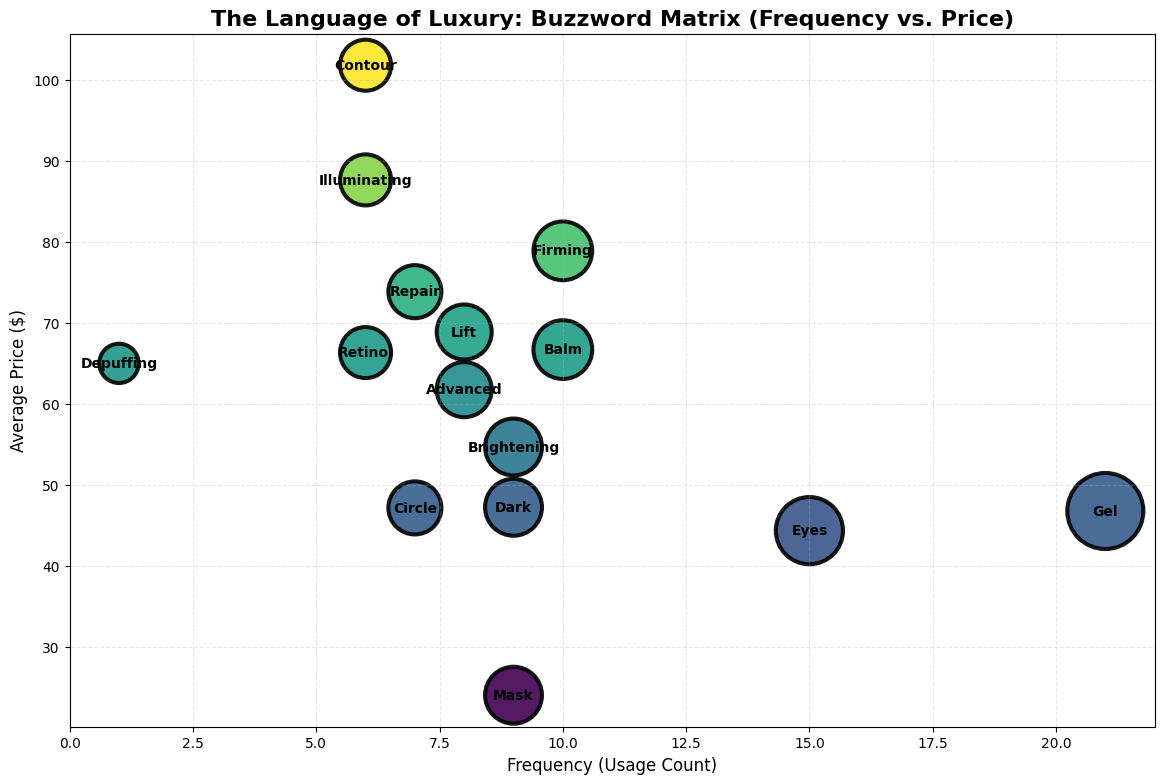

--- TOP BUZZWORD ECONOMICS ---


,Buzzword,Frequency,Avg_Price
11,Contour,6,101.833333
13,Illuminating,6,87.666667
5,Firming,10,78.900000
12,Repair,7,73.857143
7,Lift,8,68.875000
2,Balm,10,66.700000
14,Retinol,6,66.333333
8,Depuffing,1,65.000000
4,Advanced,8,61.750000
6,Brightening,9,54.666667


In [77]:
import re
from collections import Counter

# Stop list to remove high frequent words
stop_words = [
    'eye', 'cream', 'the', 'of', 'and', 'for', 'with', 'to', 'in', 'a',
    'oz', 'ml', 'size', 'mini', 'travel', 'set', 'duo', 'kit',
    'care', 'treatment', 'formula', 'skincare', 'cosmetics',
    'new', 'brand', 'collection', 'edition', 'skin','crème','serum','concentrate'
]

# Extract words
all_words = []
for name in eye_df['name']:
    # Fix: Ensure name is string to avoid errors on non-string data
    clean_name = re.sub(r'[^\w\s]', '', str(name).lower())
    words = clean_name.split()
    for w in words:
        if w not in stop_words and not w.isdigit():
            all_words.append(w)

# Get Top 15 most frequent words
top_words_list = [word[0] for word in Counter(all_words).most_common(15)]

# CALCULATE METRICS FOR THE MATRIX
word_data = []

for word in top_words_list:
    # Find all products containing this word (Word Boundary \b ensures 'age' matches 'age', not 'coverage')
    matches = eye_df[eye_df['name'].str.lower().str.contains(rf'\b{word}\b', regex=True)]

    if len(matches) > 0:
        word_data.append({
            'Buzzword': word.title(),
            'Frequency': len(matches),      # X-Axis (How common is the word?)
            'Avg_Price': matches['price'].mean() # Y-Axis (Does it command a premium?)
        })

word_matrix_df = pd.DataFrame(word_data)

# --- 4. VISUALIZE: THE BUZZWORD MATRIX ---
plt.figure(figsize=(14, 9))

sns.scatterplot(
    data=word_matrix_df,
    x='Frequency',
    y='Avg_Price',
    size='Frequency',
    sizes=(800, 3000), # Big bubbles for impact
    hue='Avg_Price',
    palette='viridis', # Darker/Yellow = Higher Price
    legend=False,
    edgecolor='black',
    alpha=0.9
)

# Label the bubbles
for i in range(word_matrix_df.shape[0]):
    plt.text(
        word_matrix_df.Frequency.iloc[i],
        word_matrix_df.Avg_Price.iloc[i],
        word_matrix_df.Buzzword.iloc[i],
        size='medium',
        weight='bold',
        color='black', # White text might be readable on dark bubbles, but black is safer
        horizontalalignment='center',
        verticalalignment='center'
    )


plt.title('The Language of Luxury: Buzzword Matrix (Frequency vs. Price)', fontsize=16, fontweight='bold')
plt.xlabel('Frequency (Usage Count)', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

# Display Data Table sorted by Price
print("--- TOP BUZZWORD ECONOMICS ---")
# Use display() if in Colab, otherwise print
try:
    display(word_matrix_df.sort_values(by='Avg_Price', ascending=False))
except NameError:
    print(word_matrix_df.sort_values(by='Avg_Price', ascending=False))